## Script to plot maps and vertical profiles (Hurricane Lane sample)

Loading modules

In [8]:
import cartopy.crs as crs
import matplotlib.pyplot as plt
import xarray as xr
from wrf import (getvar,smooth2d, interplevel, to_np, latlon_coords, get_cartopy,
                 cartopy_xlim, cartopy_ylim,CoordPair,GeoBounds,vertcross,interpline,ALL_TIMES)
import netCDF4 as nc
import numpy as np
from matplotlib.cm import get_cmap
import cartopy.feature as cfeature
from glob import glob
import pandas as pd
from matplotlib.colors import ListedColormap
from matplotlib.colors import BoundaryNorm

Loading sample data

In [9]:
ncfile = nc.Dataset("./Lane_sample/wrfout_d01_2018-08-23_18:00:00")

Loading variables using wrf-python

In [10]:
# Extract the pressure, geopotential height, and wind variables
p = getvar(ncfile, "pressure")
lm = getvar(ncfile, "LANDMASK")
slp = getvar(ncfile,"slp",units='hPa')
z = getvar(ncfile, "z", units="m")
ua = getvar(ncfile, "ua", units="kt")
va = getvar(ncfile, "va", units="kt")
wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]
ter = getvar(ncfile, "ter", timeidx=-1)
theta_e = getvar(ncfile, "theta_e", timeidx=-1)
pw = getvar(ncfile, "pw", timeidx=-1)

Set location of Tropical Cyclone using SLP minimum

In [11]:
## Location of TC
lat_tc, lon_tc = latlon_coords(slp.where(slp==slp.min(), drop=True).squeeze())

Interpolate to 500hPa pressure level using wrf-python

In [12]:
# Interpolate geopotential height, u, and v winds to 500 hPa
ht_500 = interplevel(z, p, 500)
u_500 = interplevel(ua, p, 500)
v_500 = interplevel(va, p, 500)
wspd_500 = interplevel(wspd, p, 500)

Get geographical info (coordinates, projection, cross-section points)

In [13]:
# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_500)

# Get the map projection information
cart_proj = get_cartopy(ht_500)

# Cross section points

# Set the start point and end point for the cross section
start_point = CoordPair(lat=lat_tc-2, lon=lon_tc-2)
end_point = CoordPair(lat=lat_tc+2, lon=lon_tc+2)

# Set the start point and end point for the cross section over the island
start_point_ht = CoordPair(lat=18, lon=-157.5)
end_point_ht = CoordPair(lat=21, lon=-153.75)



Calcualte vertical cross-section using wrf-python

In [14]:
# Compute the vertical cross-section interpolation.  Also, include the
# lat/lon points along the cross-section in the metadata by setting latlon
# to True.
# z_cross = vertcross(Z, z, wrfin=ncfile, start_point=start_point,
#                     end_point=end_point, latlon=True, meta=True)
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)


thetae_cross = vertcross(theta_e, z, wrfin=ncfile, start_point=start_point_ht,
                       end_point=end_point_ht, latlon=True, meta=True)

# Get the terrain heights along the cross section line
ter_line = interpline(ter, wrfin=ncfile, start_point=start_point_ht,
                      end_point=end_point_ht)

In [15]:
# Make a copy of the z cross data. Let's use regular numpy arrays for this.
thetae_cross_filled = np.ma.copy(to_np(thetae_cross))
# For each cross section column, find the first index with non-missing
# values and copy these to the missing elements below.
for i in range(thetae_cross_filled.shape[-1]):
    column_vals = thetae_cross_filled[:,i]
    # Let's find the lowest index that isn't filled. The nonzero function
    # finds all unmasked values greater than 0. 
    first_idx = int(np.transpose((column_vals > 0).nonzero())[0])
    thetae_cross_filled[0:first_idx, i] = thetae_cross_filled[first_idx, i]

### Moving to plotting
Defining 2 by 2 panel plot
* Plotting geopotential height at 500 hPa
* Plotting wind-speed cross-section
* Plotting thetae and topography

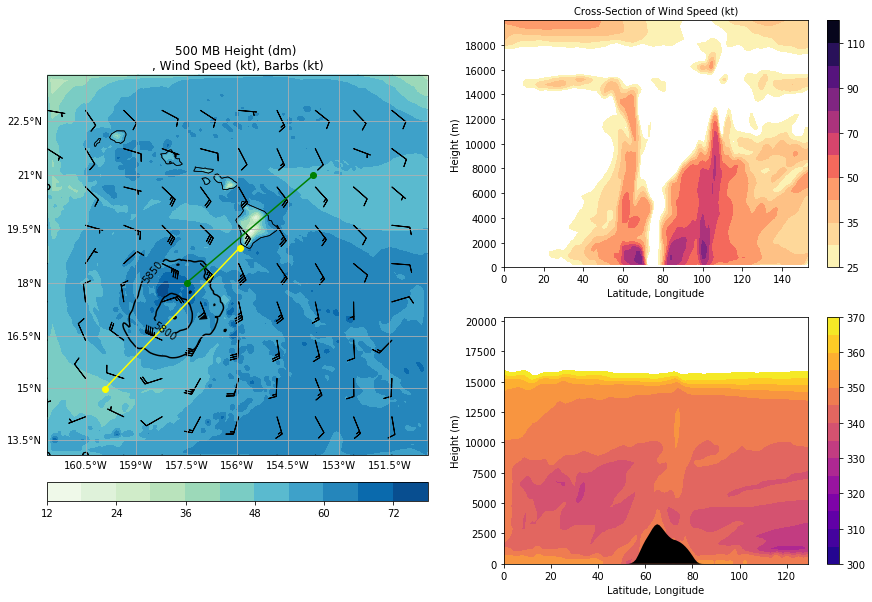

In [18]:
# Create the figure
fig = plt.figure(figsize=(15,10))

ax_h = fig.add_subplot(1,2,1,projection=cart_proj)
ax_w = fig.add_subplot(2,2,2)
ax_ht = fig.add_subplot(2,2,4)
# Download and add the states and coastlines
states = cfeature.NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax_h.add_feature(states, linewidth=0.5, edgecolor="black")
ax_h.coastlines('50m', linewidth=0.8)

# Add the 500 hPa geopotential height contours
levels = np.arange(4000., 8000., 50.)
contours = ax_h.contour(to_np(lons), to_np(lats), to_np(ht_500),
                       levels=levels, colors="black",
                       transform=crs.PlateCarree())
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the wind speed contours
levels = [25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]

wspd_contours = ax_h.contourf(to_np(lons), to_np(lats), to_np(pw),
                             10,
                             cmap=get_cmap("GnBu"),
                             transform=crs.PlateCarree())
plt.colorbar(wspd_contours, ax=ax_h, orientation="horizontal", pad=.05)


# Add the 500 hPa wind barbs, only plotting every 125th data point.
ax_h.barbs(to_np(lons[::30,::30]), to_np(lats[::30,::30]),
          to_np(u_500[::30, ::30]), to_np(v_500[::30, ::30]),
          transform=crs.PlateCarree(), length=6)

# ax_h.streamplot(to_np(lons), to_np(lats),
#           to_np(u_500), to_np(v_500), transform=crs.PlateCarree(),
#               linewidth=2, density=2, color=wspd_500.values,cmap='magma_r')

ax_h.plot([start_point.lon, end_point.lon],
            [start_point.lat, end_point.lat], color="yellow", marker="o",
            transform=crs.PlateCarree(), zorder=3)

ax_h.plot([start_point_ht.lon, end_point_ht.lon],
            [start_point_ht.lat, end_point_ht.lat], color="green", marker="o",
            transform=crs.PlateCarree(), zorder=3)

# Set the map bounds
ax_h.set_xlim(cartopy_xlim(ht_500))
ax_h.set_ylim(cartopy_ylim(ht_500))
gl = ax_h.gridlines(draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#ax_h.gridlines()

ax_h.set_title("500 MB Height (dm) \n, Wind Speed (kt), Barbs (kt)")


# Make the contour plot for wind speed
wspd_contours = ax_w.contourf(range(to_np(wspd_cross.shape[1])),to_np(wspd_cross.coords["vertical"]),to_np(wspd_cross), levels=levels,cmap=get_cmap("magma_r"))
# Add the color bar
cb_wspd = fig.colorbar(wspd_contours, ax=ax_w)
cb_wspd.ax.tick_params(labelsize=10)

# Set the y-ticks to be height
vert_vals = to_np(wspd_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
ax_w.set_ylim(0,20000)
ax_w.set_yticks(np.arange(0,20000,2000))
ax_w.set_yticklabels(np.arange(0,20000,2000), fontsize=10)

# Set the x-axis and  y-axis labels
ax_w.set_xlabel("Latitude, Longitude", fontsize=10)
ax_w.set_ylabel("Height (m)", fontsize=10)

# Add a title
ax_w.set_title("Cross-Section of Wind Speed (kt)", {"fontsize" : 10})


####
levs_thetae = np.arange(300,375,5)

thetae_contours = ax_ht.contourf(range(to_np(thetae_cross.shape[1])),to_np(thetae_cross.coords["vertical"]),to_np(thetae_cross_filled), levels=levs_thetae,cmap=get_cmap("plasma"))

# # Add the color bar
cb_thetae = fig.colorbar(thetae_contours, ax=ax_ht)
cb_thetae.ax.tick_params(labelsize=10)


# Fill in the mountain area
ht_fill = ax_ht.fill_between(range(to_np(ter_line.shape[0])), 0, to_np(ter_line),
                               facecolor="black")

# Set the x-axis and  y-axis labels
ax_ht.set_xlabel("Latitude, Longitude", fontsize=10)
ax_ht.set_ylabel("Height (m)", fontsize=10)

plt.show()